# Group Project Data Camp - Profitability prediction for movies 

### Kévin Assobo Baguéka, Antoine Gey, Robin Labbé, Ewan Sean, Joshua Wolff

The aim of this project is to predict the rentability of a movie using its characteristics like budget, genre, cast and realization crew. We make the assumption that the producer want a minimum profitability ratio (lets say 2 : the film's revenue must be at least two times bigger than its budget). Films can now be separated in two classes : those that are enough lucrative and those that are not. The problem is then reduced at a binary classification problem.

In [1]:
# general
import gc
import numpy as np
import pandas as pd
from collections import Counter 
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")
%matplotlib inline

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import VotingClassifier, GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

## 0.0. Database query

The data comes from `The Movie DataBase API (TMDB)`, but is not endorsed or certified by TMDB. We requested the database using the following python code, which is voluntarly commented because extremely time consuming (the $40.000$ lines we requested took approximately 9 hours to complete due to a data flow restrictions from the API).

In [2]:
'''

##
# Requêtes sur l'API TMDB 
##

# Librairies
import tmdbsimple as tmdb
import requests
import json
from tqdm import tqdm

# Clé de l'API TMDB pour avoir l'autorisation de faire des requêtes
tmdb.API_KEY = '4774cbd440f2c43e617d50c2b663cfcf'

# On récupère les données relatives aux films produits entre 2015 et 2018
list_years = [i for i in range(2015,2019)] # années allant de 2015 à 2018
films_id = [] # Pour stocker les identifiants uniques des films
films_infos = [] # Pour stocker les informations générales sur les films
films_credits = [] # Pour stocker les castings / équipes des films

# Récupération des identifiants uniques
print("\nRequest ID :")
for year in tqdm(list_years) :
    new_results = True
    page = 1
    while new_results :
        res = requests.get("https://api.themoviedb.org/3/discover/movie?include_adult=false&api_key="+tmdb.API_KEY+f"&year={year}"+f"&page={page}").json()
        new_results = res.get("results", [])
        films_id.extend(new_results)
        page += 1

films_id = [film["id"] for film in films_id] # On ne conserve que les identifiants

# On doit effectuer une autre série de requêtes à partir des identifiants précédents
# pour avoir accès aux informations et aux crédits (casting + équipe de tournage / production)
print("\nRequest informations :")
for id in tqdm(films_id) : 
    url_infos = "https://api.themoviedb.org/3/movie/"+str(id)+"?api_key="+tmdb.API_KEY
    url_credits = "https://api.themoviedb.org/3/movie/"+str(id)+"/credits?api_key="+tmdb.API_KEY
    films_infos.append(requests.get(url_infos).json())
    films_credits.append(requests.get(url_credits).json())

# Sauvegarde des données
with open("/Users/joshuawolff/Documents/Github/TMDB_movies_project/films_infos.json", "w") as fout:
    json.dump(films_infos, fout)
with open("/Users/joshuawolff/Documents/Github/TMDB_movies_project/films_credits.json", "w") as fout:
    json.dump(films_credits, fout)

print("\n--------- END ---------\n")


'''

'\n\n##\n# Requêtes sur l\'API TMDB \n##\n\n# Librairies\nimport tmdbsimple as tmdb\nimport requests\nimport json\nfrom tqdm import tqdm\n\n# Clé de l\'API TMDB pour avoir l\'autorisation de faire des requêtes\ntmdb.API_KEY = \'4774cbd440f2c43e617d50c2b663cfcf\'\n\n# On récupère les données relatives aux films produits entre 2015 et 2018\nlist_years = [i for i in range(2015,2019)] # années allant de 2015 à 2018\nfilms_id = [] # Pour stocker les identifiants uniques des films\nfilms_infos = [] # Pour stocker les informations générales sur les films\nfilms_credits = [] # Pour stocker les castings / équipes des films\n\n# Récupération des identifiants uniques\nprint("\nRequest ID :")\nfor year in tqdm(list_years) :\n    new_results = True\n    page = 1\n    while new_results :\n        res = requests.get("https://api.themoviedb.org/3/discover/movie?include_adult=false&api_key="+tmdb.API_KEY+f"&year={year}"+f"&page={page}").json()\n        new_results = res.get("results", [])\n        film

## 0.1. Data loading 

The two following JSON files are obtained from TMDB API using the previous code.

In [5]:
films_credits = pd.read_json("data/raw/films_credits.json.zip")
films_infos = pd.read_json("data/raw/films_infos.json")


In [4]:
films_infos.head(3)

,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,/nNmJRkg8wWnRmzQDe2FwKbPIsJV.jpg,"{'id': 86311, 'name': 'The Avengers Collection...",220000000,"[{'id': 878, 'name': 'Science Fiction'}, {'id'...",http://marvel.com/avengers_movie/,24428,tt0848228,en,The Avengers,...,2012-04-25,1518815515,143.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Some assembly required.,The Avengers,False,7.7,26156
1,False,/kzIiKLccwuzD3qD5OHFyPIkiqEw.jpg,"{'id': 23616, 'name': 'Naruto Collection', 'po...",1000000,"[{'id': 28, 'name': 'Action'}, {'id': 10749, '...",,317442,tt3717532,ja,The Last: Naruto the Movie,...,2014-12-06,16500000,114.0,"[{'english_name': 'Japanese', 'iso_639_1': 'ja...",Released,,The Last: Naruto the Movie,False,7.9,1116
2,False,/xnqust9Li4oxfhXD5kcPi3UC8i4.jpg,"{'id': 86311, 'name': 'The Avengers Collection...",365000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",http://marvel.com/movies/movie/193/avengers_ag...,99861,tt2395427,en,Avengers: Age of Ultron,...,2015-04-22,1405403694,141.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,A New Age Has Come.,Avengers: Age of Ultron,False,7.3,19169


In [5]:
films_credits.head(3)

,id,cast,crew
0,24428,"[{'adult': False, 'gender': 2, 'id': 3223, 'kn...","[{'adult': False, 'gender': 2, 'id': 37, 'know..."
1,317442,"[{'adult': False, 'gender': 1, 'id': 82055, 'k...","[{'adult': False, 'gender': 2, 'id': 80751, 'k..."
2,99861,"[{'adult': False, 'gender': 2, 'id': 3223, 'kn...","[{'adult': False, 'gender': 2, 'id': 531, 'kno..."


## 1. Cleaning the data

### 1.1. Remove duplicated rows

In [6]:
print("Number of movie identifiers in films_infos :", len(films_infos.id))
print("Number of movie identifiers in films_credits :", len(films_credits.id))

Number of movie identifiers in films_infos : 40000
Number of movie identifiers in films_credits : 40000


In [7]:
print("Number of unique movie identifiers in films_infos :", films_infos.id.nunique())
print("Number of unique movie identifiers in films_credits :", films_credits.id.nunique())

Number of unique movie identifiers in films_infos : 33689
Number of unique movie identifiers in films_credits : 33689


As we can see from above, there are duplicated movies in our data. Therefore we will remove duplicated rows.

In [8]:
films_infos = films_infos.drop_duplicates(subset='id')
films_credits = films_credits.drop_duplicates(subset='id')

print("films_infos's length :", len(films_infos))
print("films_credits's length :", len(films_credits))

films_infos's length : 33689
films_credits's length : 33689


Now we can merge the two tables.

In [9]:
films_df = films_infos.merge(
    films_credits,
    how="left",
    on="id",  
)

print("Length of the merged table :", len(films_df))

Length of the merged table : 33689


In [10]:
del films_infos, films_credits
gc.collect()

0

### 1.2. Remove useless columns

In [11]:
films_df.columns

Index(['adult', 'backdrop_path', 'belongs_to_collection', 'budget', 'genres',
       'homepage', 'id', 'imdb_id', 'original_language', 'original_title',
       'overview', 'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count', 'cast', 'crew'],
      dtype='object')

In [12]:
films_df['adult'].unique()

array([False])

There are many columns in the table, and some of them will not be useful for our model. We will remove the following :
- `adult` : because all the rows have the same value 'False'
- `backdrop_path`, `poster_path` : these columns are just links
- `imdb_id` : this one have some empty values and we already have the `id` column
- `overview` : represents the synopsis of the movie. We could process this using NLP techniques but we want to keep our model simple.
- `popularity`, `vote_average`, `vote_count` : our model is not supposed to use features that are measured after the movie is released.
- `status`: all the movies in the data are already been released

In [13]:
useful_columns = ['id', 'original_title', 'belongs_to_collection', 'release_date', 'runtime', 'budget', 'genres', \
     'original_language', 'spoken_languages',  'production_companies', 'production_countries', \
     'cast', 'crew', 'tagline', 'homepage', 'revenue']

films_df = films_df[useful_columns]

films_df.head(2)

,id,original_title,belongs_to_collection,release_date,runtime,budget,genres,original_language,spoken_languages,production_companies,production_countries,cast,crew,tagline,homepage,revenue
0,24428,The Avengers,"{'id': 86311, 'name': 'The Avengers Collection...",2012-04-25,143.0,220000000,"[{'id': 878, 'name': 'Science Fiction'}, {'id'...",en,"[{'english_name': 'English', 'iso_639_1': 'en'...","[{'id': 420, 'logo_path': '/hUzeosd33nzE5MCNsZ...","[{'iso_3166_1': 'US', 'name': 'United States o...","[{'adult': False, 'gender': 2, 'id': 3223, 'kn...","[{'adult': False, 'gender': 2, 'id': 37, 'know...",Some assembly required.,http://marvel.com/avengers_movie/,1518815515
1,317442,The Last: Naruto the Movie,"{'id': 23616, 'name': 'Naruto Collection', 'po...",2014-12-06,114.0,1000000,"[{'id': 28, 'name': 'Action'}, {'id': 10749, '...",ja,"[{'english_name': 'Japanese', 'iso_639_1': 'ja...","[{'id': 2883, 'logo_path': '/rDYExnBV61jGQnkhV...","[{'iso_3166_1': 'JP', 'name': 'Japan'}]","[{'adult': False, 'gender': 1, 'id': 82055, 'k...","[{'adult': False, 'gender': 2, 'id': 80751, 'k...",,,16500000


### 1.3. Dealing with missing values in the target

Unfortunately, we do not have the budget and the revenue for all the movies.

In [14]:
films_df.head()

,id,original_title,belongs_to_collection,release_date,runtime,budget,genres,original_language,spoken_languages,production_companies,production_countries,cast,crew,tagline,homepage,revenue
0,24428,The Avengers,"{'id': 86311, 'name': 'The Avengers Collection...",2012-04-25,143.0,220000000,"[{'id': 878, 'name': 'Science Fiction'}, {'id'...",en,"[{'english_name': 'English', 'iso_639_1': 'en'...","[{'id': 420, 'logo_path': '/hUzeosd33nzE5MCNsZ...","[{'iso_3166_1': 'US', 'name': 'United States o...","[{'adult': False, 'gender': 2, 'id': 3223, 'kn...","[{'adult': False, 'gender': 2, 'id': 37, 'know...",Some assembly required.,http://marvel.com/avengers_movie/,1518815515
1,317442,The Last: Naruto the Movie,"{'id': 23616, 'name': 'Naruto Collection', 'po...",2014-12-06,114.0,1000000,"[{'id': 28, 'name': 'Action'}, {'id': 10749, '...",ja,"[{'english_name': 'Japanese', 'iso_639_1': 'ja...","[{'id': 2883, 'logo_path': '/rDYExnBV61jGQnkhV...","[{'iso_3166_1': 'JP', 'name': 'Japan'}]","[{'adult': False, 'gender': 1, 'id': 82055, 'k...","[{'adult': False, 'gender': 2, 'id': 80751, 'k...",,,16500000
2,99861,Avengers: Age of Ultron,"{'id': 86311, 'name': 'The Avengers Collection...",2015-04-22,141.0,365000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",en,"[{'english_name': 'English', 'iso_639_1': 'en'...","[{'id': 420, 'logo_path': '/hUzeosd33nzE5MCNsZ...","[{'iso_3166_1': 'US', 'name': 'United States o...","[{'adult': False, 'gender': 2, 'id': 3223, 'kn...","[{'adult': False, 'gender': 2, 'id': 531, 'kno...",A New Age Has Come.,http://marvel.com/movies/movie/193/avengers_ag...,1405403694
3,347201,BORUTO -NARUTO THE MOVIE-,"{'id': 23616, 'name': 'Naruto Collection', 'po...",2015-08-07,95.0,0,"[{'id': 16, 'name': 'Animation'}, {'id': 28, '...",ja,"[{'english_name': 'Japanese', 'iso_639_1': 'ja...","[{'id': 3234, 'logo_path': '/wTPPnz05ZCQgEQVeS...","[{'iso_3166_1': 'JP', 'name': 'Japan'}]","[{'adult': False, 'gender': 1, 'id': 1201637, ...","[{'adult': False, 'gender': 2, 'id': 68923, 'k...",Forge your own path.,,40200000
4,303857,ドラゴンボールZ 復活の「F」,"{'id': 620873, 'name': 'Dragon Ball Super Coll...",2015-04-18,93.0,5000000,"[{'id': 28, 'name': 'Action'}, {'id': 16, 'nam...",ja,"[{'english_name': 'Japanese', 'iso_639_1': 'ja...","[{'id': 7485, 'logo_path': '/vpOrqLxZ6JkrCFdi3...","[{'iso_3166_1': 'JP', 'name': 'Japan'}, {'iso_...","[{'adult': False, 'gender': 1, 'id': 90496, 'k...","[{'adult': False, 'gender': 2, 'id': 78322, 'k...",,http://www.dragonball2015.com/,61768190


In [15]:
films_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33689 entries, 0 to 33688
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     33689 non-null  int64  
 1   original_title         33689 non-null  object 
 2   belongs_to_collection  2384 non-null   object 
 3   release_date           33689 non-null  object 
 4   runtime                33114 non-null  float64
 5   budget                 33689 non-null  int64  
 6   genres                 33689 non-null  object 
 7   original_language      33689 non-null  object 
 8   spoken_languages       33689 non-null  object 
 9   production_companies   33689 non-null  object 
 10  production_countries   33689 non-null  object 
 11  cast                   33689 non-null  object 
 12  crew                   33689 non-null  object 
 13  tagline                33689 non-null  object 
 14  homepage               30769 non-null  object 
 15  re

Even if we see non-null values only for `runtime` and `belongs_to_collection`, there are missing values in other forms :

- for `budget`, `runtime` and `revenue` some movies have values equal to 0 which is not necessarily real. 

- for the features whose values are lists, there are empty lists which are not counted as null values.

In [16]:
print("Number of movies for which we have the budget :", len(films_df[films_df['budget'] > 0]))
print("Number of movies for which we have the revenue :", len(films_df[films_df['revenue'] > 0]))
print("Number of movies for which we have the budget and the revenue :",
 len(films_df[(films_df['budget'] > 0) & (films_df['revenue'] > 0)]))
print("Number of movies for which we have the revenue but not the budge:",
 len(films_df[(films_df['budget'] <= 0) & (films_df['revenue'] > 0)]))


Number of movies for which we have the budget : 4618
Number of movies for which we have the revenue : 3449
Number of movies for which we have the budget and the revenue : 2302
Number of movies for which we have the revenue but not the budge: 1147


Since our goal is to predict whether or not a movie will generate twice its budget in revenue, we will only consider the movies for which we have both the budget and the revenue. We define a variable which value is:

- 1 if revenue / budget >= 2
- 0 otherwise

In [17]:
films_df = films_df[np.array(films_df['revenue'] > 0) & np.array(films_df['budget'] > 0)]

desired_rentability = 2
films_df["class"] = np.int8((films_df["revenue"] / films_df["budget"]) >= desired_rentability)

## 2. Feature Engineering

We start by splitting the data into training and test sets.

In [18]:
train_df, test_df = train_test_split(films_df, test_size=0.33, random_state=12)

We impute missing values for `runtime`

In [19]:
mean_runtime = train_df['runtime'].mean()

train_df['runtime']=train_df['runtime'].fillna(0.0).replace(0.0, mean_runtime)
test_df['runtime']=test_df['runtime'].fillna(0.0).replace(0.0, mean_runtime)

Now we will process all the features of our dataset so that we can use them in our model.

### 2.1. Release date

In [20]:
train_df['release_date'] = pd.to_datetime(train_df['release_date'])
test_df['release_date'] = pd.to_datetime(test_df['release_date'])

In [21]:
print("Oldest release date :", train_df['release_date'].min())
print("Latest release date :", train_df['release_date'].max())

Oldest release date : 1925-12-25 00:00:00
Latest release date : 2019-08-09 00:00:00


We extract different time units from the release date.

In [22]:
def process_release_date(df):
    df['release_year'] = df['release_date'].dt.year
    df['release_month'] = df['release_date'].dt.month
    df['release_day'] = df['release_date'].dt.day
    df['release_weekday'] = df['release_date'].dt.weekday

In [23]:
process_release_date(train_df)
process_release_date(test_df)

<AxesSubplot:xlabel='release_day', ylabel='count'>

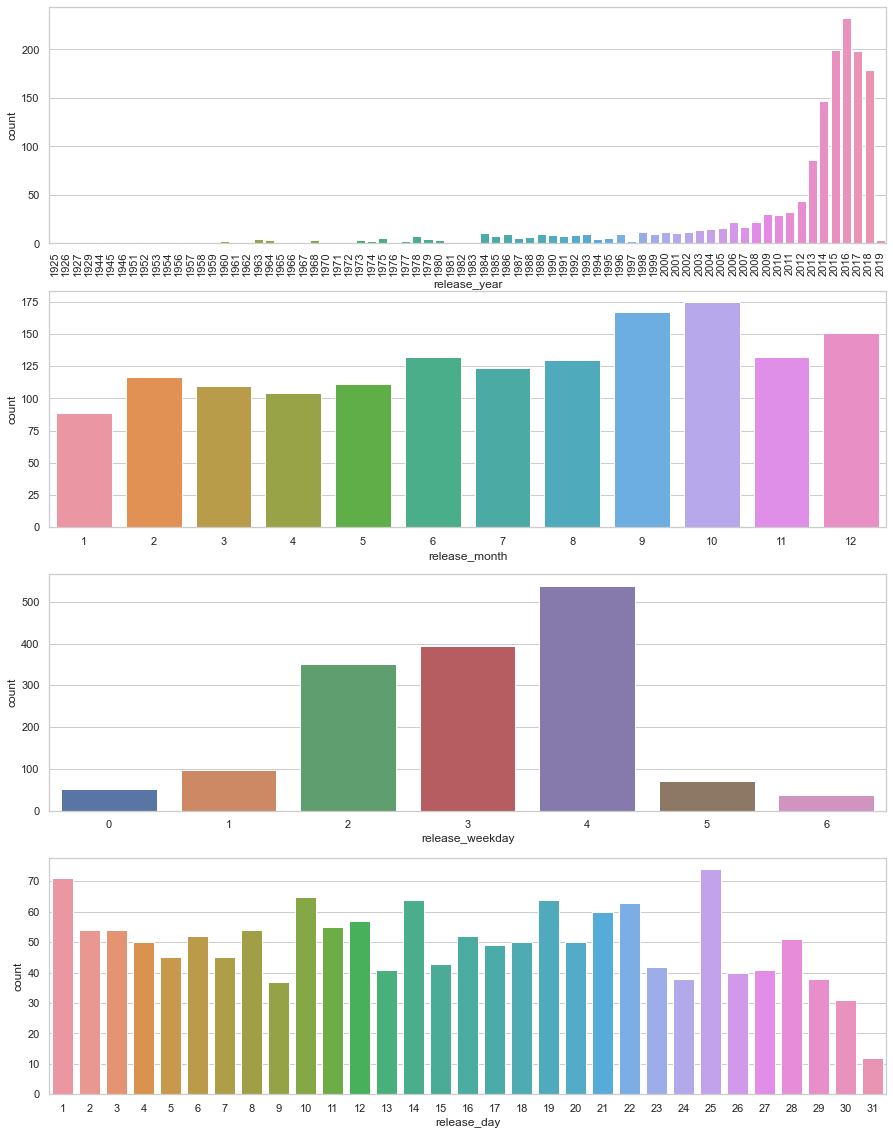

In [24]:
fig, axes = plt.subplots(4, 1, figsize=(15,20))

sns.countplot(data=train_df, x='release_year', ax=axes[0])
axes[0].tick_params(axis='x', labelrotation=90, size=4)

sns.countplot(data=train_df, x='release_month', ax=axes[1])
sns.countplot(data=train_df, x='release_weekday', ax=axes[2])
sns.countplot(data=train_df, x='release_day', ax=axes[3])

Most movies in the dataset were released after 2000. Also they are generally released between Wednesday and Friday. Let's see how the revenue vary with the time.

<AxesSubplot:xlabel='release_day', ylabel='revenue'>

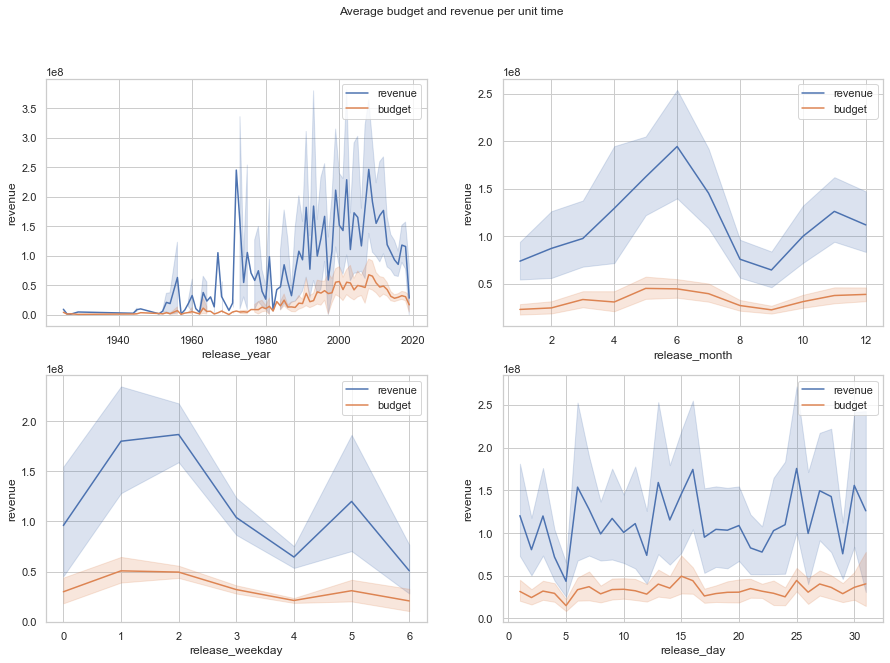

In [25]:
fig, axes = plt.subplots(2, 2, figsize=(15,10))
fig.suptitle("Average budget and revenue per unit time")
sns.lineplot(data=train_df, y='revenue', x='release_year', ax=axes[0,0], label='revenue')
sns.lineplot(data=train_df, y='revenue', x='release_month', ax=axes[0,1], label='revenue')
sns.lineplot(data=train_df, y='revenue', x='release_weekday', ax=axes[1,0], label='revenue')
sns.lineplot(data=train_df, y='revenue', x='release_day', ax=axes[1,1], label='revenue')

sns.lineplot(data=train_df, y='budget', x='release_year', ax=axes[0,0], label='budget')
sns.lineplot(data=train_df, y='budget', x='release_month', ax=axes[0,1], label='budget')
sns.lineplot(data=train_df, y='budget', x='release_weekday', ax=axes[1,0], label='budget')
sns.lineplot(data=train_df, y='budget', x='release_day', ax=axes[1,1], label='budget')

The revenue is higher for movies released after 2000. The highest revenues seem to be reached between May and July.

### 2.2. Collection, Homepage and Tagline

In [26]:
train_df['belongs_to_collection'].apply(lambda x: len(x) if x != None else 0).value_counts()

0    1153
4     389
Name: belongs_to_collection, dtype: int64

1820 values in this column are empty, 490 contrain information about the collections.

Adding a collection_name column which contains name of the collection 

In [27]:
train_df['collection_name'] = train_df['belongs_to_collection'].apply(lambda x: x['name'] if x != None else '')
test_df['collection_name'] = test_df['belongs_to_collection'].apply(lambda x: x['name'] if x != None else '')

Adding a has_collection column which will tell if the movie belongs to a specific colllection
- 1 : if movie belongs to a collection
- 0 : if it does'nt belong to any collection

In [28]:
train_df['has_collection'] = train_df['belongs_to_collection'].apply(lambda x: 1 if x != None else 0)
test_df['has_collection'] = test_df['belongs_to_collection'].apply(lambda x: 1 if x != None else 0)

We do the same thing for `homepage` and `tagline`

In [29]:
train_df['has_homepage'] = train_df['homepage'].apply(lambda x: 0 if x == '' else 1)
test_df['has_homepage'] = test_df['homepage'].apply(lambda x: 0 if x == '' else 1)

train_df['has_a_tagline'] = train_df['tagline'].apply(lambda x: 0 if x == '' else 1)
test_df['has_a_tagline'] = test_df['tagline'].apply(lambda x: 0 if x == '' else 1)

Now we dont need the `belongs_to_collection`, `homepage` and `tagline` columns so we will drop it in both the sets

In [30]:
train_df = train_df.drop(['belongs_to_collection', 'homepage', 'tagline'], axis=1)
test_df = test_df.drop(['belongs_to_collection', 'homepage', 'tagline'], axis=1)

<AxesSubplot:xlabel='has_a_tagline', ylabel='count'>

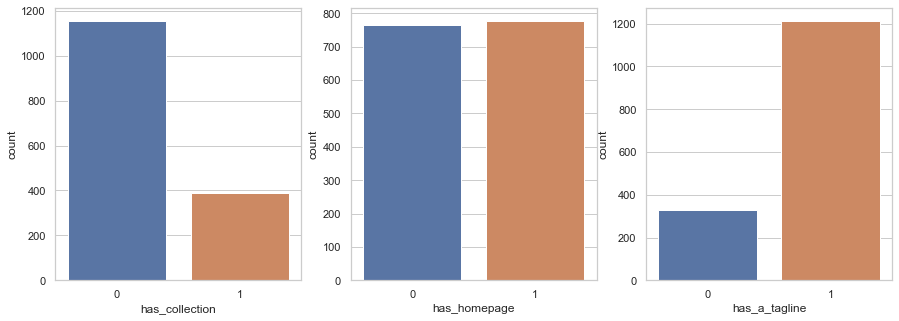

In [31]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.countplot(x=train_df['has_collection'], ax=axes[0])
sns.countplot(x=train_df['has_homepage'], ax=axes[1])
sns.countplot(x=train_df['has_a_tagline'], ax=axes[2])

Most movies have a tagline but most of them also do not belong to a collection. Let's see how these features affect the revenue.

<AxesSubplot:xlabel='has_a_tagline', ylabel='revenue'>

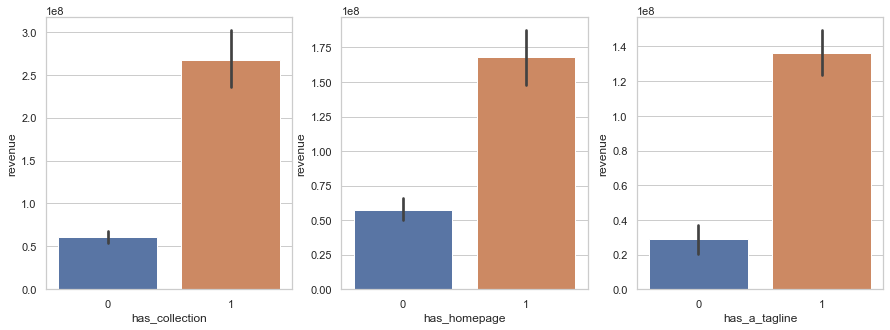

In [32]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.barplot(data=train_df, x='has_collection', y='revenue', ax=axes[0])
sns.barplot(data=train_df, x='has_homepage', y='revenue', ax=axes[1])
sns.barplot(data=train_df, x='has_a_tagline', y='revenue', ax=axes[2])

Having a collection, homepage or tagline seems to increase the revenue of the movie.

### 2.3. Original Language

<AxesSubplot:xlabel='original_language', ylabel='count'>

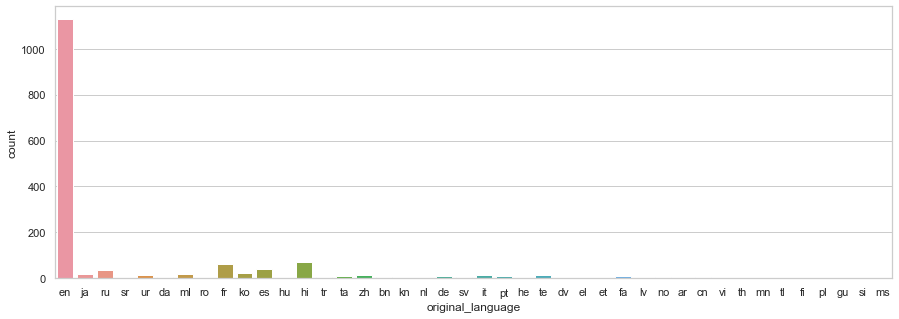

In [33]:
plt.figure(figsize=(15,5))
sns.countplot(x=train_df['original_language'])

Most of the movies are in English. We will do a simple one hot encoding for this column.

### 2.4. Spoken Languages

In [34]:
train_df.loc[19361, 'spoken_languages']

[{'english_name': 'English', 'iso_639_1': 'en', 'name': 'English'}]

In [35]:
print('Number of spoken languages in films')
train_df['spoken_languages'].apply(lambda x: len(x) if x != [] else 0).value_counts()

Number of spoken languages in films


1     1086
2      254
3      111
4       47
5       25
0        9
6        6
7        2
8        1
11       1
Name: spoken_languages, dtype: int64

For most movies there is only one spoken language. Let's compute the most common ones

In [36]:
list_of_languages = list(
    train_df['spoken_languages']
    .apply(lambda x: [i['english_name'] for i in x] if x != [] else [])
    .values
)

In [37]:
most_common_languages = Counter([language for list_ in list_of_languages for language in list_ ]).most_common(30)
most_common_languages

[('English', 1201),
 ('French', 145),
 ('Spanish', 138),
 ('German', 103),
 ('Russian', 99),
 ('Hindi', 83),
 ('Italian', 60),
 ('Japanese', 46),
 ('Mandarin', 40),
 ('Arabic', 28),
 ('Portuguese', 28),
 ('Korean', 27),
 ('Malayalam', 21),
 ('Urdu', 19),
 ('Turkish', 17),
 ('Tamil', 17),
 ('Latin', 16),
 ('Swedish', 16),
 ('Cantonese', 15),
 ('Greek', 14),
 ('Telugu', 14),
 ('Polish', 12),
 ('Persian', 11),
 ('Norwegian', 9),
 ('Hebrew', 8),
 ('Hungarian', 8),
 ('Thai', 8),
 ('Vietnamese', 7),
 ('Danish', 6),
 ('Bengali', 6)]

We add a feature `num_languages` which represents the number of spoken languages in the movie

In [38]:
train_df['num_languages'] = train_df['spoken_languages'].apply(lambda x: len(x) if x != [] else 0)
test_df['num_languages'] = test_df['spoken_languages'].apply(lambda x: len(x) if x != [] else 0)

We encode the most common languages as features.

In [39]:
# We get all the english names of the spoken languages in the movie
train_df['all_languages'] = (
    train_df['spoken_languages']
    .apply(lambda x: [language['english_name'].lower() for language in x] if x != [] else [])
)

# Then for each one of the most common language, we look up if it is part 
# of the spoken language in the movie
top_30_languages = [language[0].lower() for language in most_common_languages]

for language in top_30_languages:
    train_df['language_' + language] = (
        train_df['all_languages']
        .apply(lambda x: 1 if language in x else 0)
    )

In [40]:
# We get all the english names of the spoken languages in the movie
test_df['all_languages'] = (
    test_df['spoken_languages']
    .apply(lambda x: [language['english_name'].lower() for language in x] if x != [] else [])
)

# Then for each one of the most common language, we look up if it is part 
# of the spoken language in the movie
for language in top_30_languages:
    test_df['language_' + language] = (
        test_df['all_languages']
        .apply(lambda x: 1 if language in x else 0)
    )

For each one of the 30 most common language we have a boolean feature equals to 1 if the language is spoken in the movie. We can drop the initial column.

In [41]:
train_df.drop(columns=['spoken_languages', 'all_languages'], inplace=True)
test_df.drop(columns=['spoken_languages', 'all_languages'], inplace=True)

### 2.5. Genres

We will use the same analysis we used for the spoken languages.

In [42]:
print('Number of genres in movies')
train_df['genres'].apply(lambda x: len(x) if x != [] else 0).value_counts()

Number of genres in movies


3    531
2    480
1    269
4    216
5     37
6      8
0      1
Name: genres, dtype: int64

For most movies there are two or three genres. Let's compute the most common ones

In [43]:
train_df.loc[19361, 'genres']

[{'id': 10749, 'name': 'Romance'},
 {'id': 878, 'name': 'Science Fiction'},
 {'id': 53, 'name': 'Thriller'},
 {'id': 18, 'name': 'Drama'}]

In [44]:
list_of_genres = list(
    train_df['genres']
    .apply(lambda x: [genre['name'] for genre in x] if x != [] else [])
    .values
)

most_common_genres = Counter([genre for list_ in list_of_genres for genre in list_ ]).most_common()
most_common_genres

[('Drama', 720),
 ('Comedy', 489),
 ('Action', 435),
 ('Thriller', 381),
 ('Adventure', 290),
 ('Romance', 236),
 ('Crime', 219),
 ('Science Fiction', 183),
 ('Family', 164),
 ('Horror', 161),
 ('Fantasy', 159),
 ('Mystery', 119),
 ('Animation', 113),
 ('History', 103),
 ('War', 63),
 ('Music', 50),
 ('Documentary', 17),
 ('Western', 15),
 ('TV Movie', 2)]

In [45]:
len(most_common_genres)

19

There are 19 genres of movies in the training set. We add a feature `num_genres` which represents the number of genres in the movie

In [46]:
train_df['num_genres'] = train_df['genres'].apply(lambda x: len(x) if x != [] else 0)
test_df['num_genres'] = test_df['genres'].apply(lambda x: len(x) if x != [] else 0)

We encode the genres as features.

In [47]:
# We get all the names of all the genres of the movie
train_df['all_genres'] = (
    train_df['genres']
    .apply(lambda x: [genre['name'].lower() for genre in x] if x != [] else [])
)

# Then for each one of the most common genre, we look up if it is part 
# of the genres of the movie
top_genres = [genre[0].lower() for genre in most_common_genres]

for genre in top_genres:
    train_df['genre_' + genre] = (
        train_df['all_genres']
        .apply(lambda x: 1 if genre in x else 0)
    )

In [48]:
# We get all the names of all the genres of the movie
test_df['all_genres'] = (
    test_df['genres']
    .apply(lambda x: [genre['name'].lower() for genre in x] if x != [] else [])
)

# Then for each one of the most common genre, we look up if it is part 
# of the genres of the movie

for genre in top_genres:
    test_df['genre_' + genre] = (
        test_df['all_genres']
        .apply(lambda x: 1 if genre in x else 0)
    )

For each one of the 19 most common genres we have a boolean feature equals to 1 if the genre is one of the movie. We can drop the initial column.

In [49]:
train_df.drop(columns=['genres', 'all_genres'], inplace=True)
test_df.drop(columns=['genres', 'all_genres'], inplace=True)

### 2.6. Production companies

Once again we do the same analysis.

In [50]:
train_df.loc[19361, 'production_companies']

[{'id': 59403,
  'logo_path': None,
  'name': 'Miracle Mile Productions Inc.',
  'origin_country': ''},
 {'id': 3952, 'logo_path': None, 'name': 'Hemdale Film', 'origin_country': ''}]

In [51]:
print('Number of production companies for movies')
train_df['production_companies'].apply(lambda x: len(x) if x != [] else 0).value_counts()

Number of production companies for movies


2     318
3     311
1     276
4     221
5     124
6     105
7      58
8      39
9      21
0      20
10     15
11     12
13      6
12      6
18      2
17      2
16      2
15      1
22      1
21      1
14      1
Name: production_companies, dtype: int64

For most movies there are two or one production companies. Let's compute the most common ones

In [52]:
list_of_companies = list(
    train_df['production_companies']
    .apply(lambda x: [company['name'] for company in x] if x != [] else [])
    .values
)

# We take the companies which have >= 20 occurences
most_common_companies = Counter([company for list_ in list_of_companies for company in list_ ]).most_common(27)
most_common_companies

[('Universal Pictures', 129),
 ('Warner Bros. Pictures', 82),
 ('Columbia Pictures', 78),
 ('Paramount', 67),
 ('20th Century Fox', 60),
 ('Lionsgate', 44),
 ('Canal+', 42),
 ('New Line Cinema', 34),
 ('Walt Disney Pictures', 33),
 ('Sony Pictures', 32),
 ('TSG Entertainment', 30),
 ('Metro-Goldwyn-Mayer', 28),
 ('DreamWorks Pictures', 27),
 ('StudioCanal', 26),
 ('Blumhouse Productions', 25),
 ('Village Roadshow Pictures', 22),
 ('United Artists', 22),
 ('Relativity Media', 21),
 ('RatPac Entertainment', 21),
 ('Legendary Pictures', 21),
 ('Ciné+', 21),
 ('Dune Entertainment', 19),
 ('Amblin Entertainment', 19),
 ('Imagine Entertainment', 19),
 ('Summit Entertainment', 19),
 ('Working Title Films', 18),
 ('TriStar Pictures', 18)]

We add a feature `num_companies` which represents the number of production companies of the movie

In [53]:
train_df['num_companies'] = train_df['production_companies'].apply(lambda x: len(x) if x != [] else 0)
test_df['num_companies'] = test_df['production_companies'].apply(lambda x: len(x) if x != [] else 0)

We encode the most common production companies as features.

In [54]:
# We get all the names of all the prod companies of the movie
train_df['all_companies'] = (
    train_df['production_companies']
    .apply(lambda x: [company['name'] for company in x] if x != [] else [])
)

# Then for each one of the 27 most common company, we look up if it is part 
# of the companies of the movie
top_companies = [company[0] for company in most_common_companies]

for company in top_companies:
    train_df['company_' + '_'.join(company.lower().split())] = (
        train_df['all_companies']
        .apply(lambda x: 1 if company in x else 0)
    )

In [55]:
# We get all the names of all the prod companies of the movie
test_df['all_companies'] = (
    test_df['production_companies']
    .apply(lambda x: [company['name'] for company in x] if x != [] else [])
)

# Then for each one of the 27 most common company, we look up if it is part 
# of the companies of the movie

for company in top_companies:
    test_df['company_' + '_'.join(company.lower().split())] = (
        test_df['all_companies']
        .apply(lambda x: 1 if company in x else 0)
    )

For each one of the 27 most common companies we have a boolean feature equals to 1 if the company is one of the movie. We can drop the initial column.

In [56]:
train_df.drop(columns=['production_companies', 'all_companies'], inplace=True)
test_df.drop(columns=['production_companies', 'all_companies'], inplace=True)

### 2.7. Production countries

Same analysis !

In [57]:
train_df.loc[19361, 'production_countries']

[{'iso_3166_1': 'US', 'name': 'United States of America'}]

In [58]:
print('Number of production countries for movies')
train_df['production_countries'].apply(lambda x: len(x) if x != [] else 0).value_counts()

Number of production countries for movies


1    1073
2     286
3     106
4      43
5      16
0      14
6       4
Name: production_countries, dtype: int64

For most movies there are one or two production countries. Let's compute the most common ones

In [59]:
list_of_countries = list(
    train_df['production_countries']
    .apply(lambda x: [country['name'] for country in x] if x != [] else [])
    .values
)

# We take the countries which have >= 20 occurences
most_common_countries = Counter([country for list_ in list_of_countries for country in list_ ]).most_common(21)
most_common_countries

[('United States of America', 1027),
 ('United Kingdom', 222),
 ('France', 147),
 ('India', 128),
 ('Germany', 89),
 ('Canada', 75),
 ('Spain', 47),
 ('China', 43),
 ('Russia', 40),
 ('Belgium', 36),
 ('Japan', 34),
 ('Australia', 32),
 ('Italy', 28),
 ('South Korea', 27),
 ('Hong Kong', 19),
 ('Sweden', 18),
 ('Pakistan', 12),
 ('Czech Republic', 12),
 ('Denmark', 11),
 ('Mexico', 11),
 ('Ireland', 11)]

We add a feature `num_countries` which represents the number of production countries of the movie

In [60]:
train_df['num_countries'] = train_df['production_countries'].apply(lambda x: len(x) if x != [] else 0)
test_df['num_countries'] = test_df['production_countries'].apply(lambda x: len(x) if x != [] else 0)

We encode the most common production countries as features.

In [61]:
# We get all the names of all the prod countries of the movie
train_df['all_countries'] = (
    train_df['production_countries']
    .apply(lambda x: [country['name'] for country in x] if x != [] else [])
)

# Then for each one of the 21 most common country, we look up if it is part 
# of the countries of the movie
top_countries = [country[0] for country in most_common_countries]

for country in top_countries:
    train_df['country_' + '_'.join(country.lower().split())] = (
        train_df['all_countries']
        .apply(lambda x: 1 if country in x else 0)
    )

In [62]:
# We get all the names of all the prod countries of the movie
test_df['all_countries'] = (
    test_df['production_countries']
    .apply(lambda x: [country['name'] for country in x] if x != [] else [])
)

# Then for each one of the 21 most common country, we look up if it is part 
# of the countries of the movie

for country in top_countries:
    test_df['country_' + '_'.join(country.lower().split())] = (
        test_df['all_countries']
        .apply(lambda x: 1 if country in x else 0)
    )

For each one of the 27 most common companies we have a boolean feature equals to 1 if the company is one of the movie. We can drop the initial column.

In [63]:
train_df.drop(columns=['production_countries', 'all_countries'], inplace=True)
test_df.drop(columns=['production_countries', 'all_countries'], inplace=True)

### 2.8. Cast

Same analysis !

In [64]:
train_df.loc[19361, 'cast']

[{'adult': False,
  'gender': 2,
  'id': 11085,
  'known_for_department': 'Acting',
  'name': 'Anthony Edwards',
  'original_name': 'Anthony Edwards',
  'popularity': 9.865,
  'profile_path': '/rP88gP87pa3je6Viem3081tESIV.jpg',
  'cast_id': 1,
  'character': 'Harry Washello',
  'credit_id': '52fe44a6c3a368484e02f029',
  'order': 0},
 {'adult': False,
  'gender': 1,
  'id': 51544,
  'known_for_department': 'Acting',
  'name': 'Mare Winningham',
  'original_name': 'Mare Winningham',
  'popularity': 10.916,
  'profile_path': '/nXawdsVgNQp4Q41vu735nvajIT9.jpg',
  'cast_id': 2,
  'character': 'Julie Peters',
  'credit_id': '52fe44a6c3a368484e02f02d',
  'order': 1},
 {'adult': False,
  'gender': 2,
  'id': 103071,
  'known_for_department': 'Acting',
  'name': 'John Agar',
  'original_name': 'John Agar',
  'popularity': 3.259,
  'profile_path': '/zIFQzZaSUzsRGh0EdaLeFr1bJHW.jpg',
  'cast_id': 4,
  'character': 'Ivan Peters',
  'credit_id': '52fe44a6c3a368484e02f037',
  'order': 2},
 {'adult':

In [65]:
print('Number of casted persons in the movies')
train_df['cast'].apply(lambda x: len(x) if x != [] else 0).value_counts()

Number of casted persons in the movies


19     49
18     47
23     42
20     42
16     36
       ..
155     1
122     1
126     1
227     1
121     1
Name: cast, Length: 124, dtype: int64

In [66]:
list_of_cast_names = list(
    train_df['cast']
    .apply(lambda x: [casted['name'] for casted in x] if x != [] else [])
    .values
)

# We take the countries which have >= 15 occurences
most_common_casted = Counter([casted for list_ in list_of_cast_names for casted in list_ ]).most_common(29)
most_common_casted

[('Samuel L. Jackson', 23),
 ('Morgan Freeman', 20),
 ('Liam Neeson', 20),
 ('Michael Papajohn', 19),
 ('Johnny Otto', 18),
 ('John Goodman', 17),
 ('J.K. Simmons', 17),
 ('Frank Welker', 17),
 ('Willem Dafoe', 16),
 ('Stan Lee', 16),
 ('Michael Fassbender', 15),
 ('Toby Jones', 15),
 ('Alec Baldwin', 14),
 ('Wayne Pére', 14),
 ('Dwayne Johnson', 14),
 ('James Franco', 14),
 ('Vin Diesel', 14),
 ('David Thewlis', 14),
 ('Octavia Spencer', 14),
 ('Robert De Niro', 14),
 ('Gary Oldman', 14),
 ('Steve Buscemi', 13),
 ('Keegan-Michael Key', 13),
 ('Owen Wilson', 13),
 ('Elizabeth Banks', 13),
 ('Arnold Schwarzenegger', 13),
 ('Daniel Westwood', 13),
 ('Woody Harrelson', 13),
 ('Matt Damon', 13)]

We add a feature `num_casted` which represents the number of casted persons in the movie

In [67]:
train_df['num_casted'] = train_df['cast'].apply(lambda x: len(x) if x != [] else 0)
test_df['num_casted'] = test_df['cast'].apply(lambda x: len(x) if x != [] else 0)

We encode the most common casted persons as features.

In [68]:
# We get all the names of all the casted persons the movie
train_df['all_casted'] = (
    train_df['cast']
    .apply(lambda x: [casted['name'] for casted in x] if x != [] else [])
)

# Then for each one of the 29 most common casted, we look up if it is part 
# of the casted persons in the movie
top_cast = [casted[0] for casted in most_common_casted]

for casted in top_cast:
    train_df['cast_' + '_'.join(casted.lower().split())] = (
        train_df['all_casted']
        .apply(lambda x: 1 if casted in x else 0)
    )

In [69]:
# We get all the names of all the casted persons the movie
test_df['all_casted'] = (
    test_df['cast']
    .apply(lambda x: [casted['name'] for casted in x] if x != [] else [])
)

# Then for each one of the 29 most common casted, we look up if it is part 
# of the casted persons in the movie
top_cast = [casted[0] for casted in most_common_casted]

for casted in top_cast:
    test_df['cast_' + '_'.join(casted.lower().split())] = (
        test_df['all_casted']
        .apply(lambda x: 1 if casted in x else 0)
    )

For each one of the 29 most common casted we have a boolean feature equals to 1 if the person is in the movie. We can drop the initial column.

In [70]:
train_df.drop(columns=['cast', 'all_casted'], inplace=True)
test_df.drop(columns=['cast', 'all_casted'], inplace=True)

### 2.9. Crew

Same analysis !

In [71]:
train_df.loc[19361, 'crew']

[{'adult': False,
  'gender': 2,
  'id': 601,
  'known_for_department': 'Art',
  'name': 'David L. Snyder',
  'original_name': 'David L. Snyder',
  'popularity': 1.587,
  'profile_path': '/u6mr5Eaz85CA53BsuLRicdl6gvp.jpg',
  'credit_id': '60884f21b6abc400298b80ad',
  'department': 'Art',
  'job': 'Conceptual Design'},
 {'adult': False,
  'gender': 2,
  'id': 2214,
  'known_for_department': 'Sound',
  'name': 'Paul Haslinger',
  'original_name': 'Paul Haslinger',
  'popularity': 1.528,
  'profile_path': None,
  'credit_id': '55b5155dc3a3682190006b1c',
  'department': 'Sound',
  'job': 'Original Music Composer'},
 {'adult': False,
  'gender': 2,
  'id': 2720,
  'known_for_department': 'Production',
  'name': 'Derek Gibson',
  'original_name': 'Derek Gibson',
  'popularity': 0.6000000000000001,
  'profile_path': None,
  'credit_id': '55b51520c3a3683002014631',
  'department': 'Production',
  'job': 'Producer'},
 {'adult': False,
  'gender': 2,
  'id': 2721,
  'known_for_department': 'Prod

In [72]:
print('Number of crew members for the movies')
train_df['crew'].apply(lambda x: len(x) if x != [] else 0).value_counts()

Number of crew members for the movies


24     34
16     33
9      31
22     30
8      27
       ..
727     1
216     1
279     1
145     1
245     1
Name: crew, Length: 287, dtype: int64

In [73]:
list_of_crew_names = list(
    train_df['crew']
    .apply(lambda x: [crew_member['name'] for crew_member in x] if x != [] else [])
    .values
)

# We take the 30 most common crew members
most_common_crew_members = Counter([crew_member for list_ in list_of_crew_names for crew_member in list_ ]).most_common(30)
most_common_crew_members

[("Dan O'Connell", 61),
 ('John T. Cucci', 57),
 ('Barbara Harris', 44),
 ('Steven Spielberg', 40),
 ('James Ashwill', 38),
 ('Hans Bjerno', 38),
 ("Thomas J. O'Connell", 37),
 ('Francine Maisler', 37),
 ('Mary Vernieu', 37),
 ('John Papsidera', 37),
 ('Stan Lee', 36),
 ('Chris Navarro', 34),
 ('John Roesch', 33),
 ('Harvey Weinstein', 32),
 ('Bob Weinstein', 31),
 ('Avy Kaufman', 28),
 ('Steven Mnuchin', 28),
 ('Tricia Wood', 28),
 ('Michael Miller', 27),
 ('Skip Lievsay', 27),
 ('Peter Burgis', 26),
 ('Jason Blum', 26),
 ('David B. Nowell', 26),
 ('Andy Nelson', 26),
 ('Deborah Aquila', 26),
 ('Anna Behlmer', 25),
 ('Gary Rydstrom', 24),
 ('Randy Thom', 24),
 ('Nerses Gezalyan', 24),
 ('John C. Stuver', 24)]

We add a feature `num_crew_members` which represents the number of crew members for the movie

In [74]:
train_df['num_crew_members'] = train_df['crew'].apply(lambda x: len(x) if x != [] else 0)
test_df['num_crew_members'] = test_df['crew'].apply(lambda x: len(x) if x != [] else 0)

We encode the most common casted persons as features.

In [75]:
# We get the names of all the crew members for the movie
train_df['all_crew_members'] = (
    train_df['crew']
    .apply(lambda x: [crew_member['name'] for crew_member in x] if x != [] else [])
)

# Then for each one of the 30 most common crew members, we look up if it is part 
# of the crew members for the movie
top_crew_members = [crew_member[0] for crew_member in most_common_crew_members]

for crew_member in top_crew_members:
    train_df['crew_' + '_'.join(crew_member.lower().split())] = (
        train_df['all_crew_members']
        .apply(lambda x: 1 if crew_member in x else 0)
    )

In [76]:
# We get the names of all the crew members for the movie
test_df['all_crew_members'] = (
    test_df['crew']
    .apply(lambda x: [crew_member['name'] for crew_member in x] if x != [] else [])
)

# Then for each one of the 30 most common crew members, we look up if it is part 
# of the crew members for the movie

for crew_member in top_crew_members:
    test_df['crew_' + '_'.join(crew_member.lower().split())] = (
        test_df['all_crew_members']
        .apply(lambda x: 1 if crew_member in x else 0)
    )

For each one of the 30 most common crew memebers we have a boolean feature equals to 1 if the person is in the crew of the movie. We can drop the initial column.

In [77]:
train_df.drop(columns=['crew', 'all_crew_members'], inplace=True)
test_df.drop(columns=['crew', 'all_crew_members'], inplace=True)

## 3. Preprocessing

In [78]:
train_df.head()

,id,original_title,release_date,runtime,budget,original_language,revenue,class,release_year,release_month,...,crew_peter_burgis,crew_jason_blum,crew_david_b._nowell,crew_andy_nelson,crew_deborah_aquila,crew_anna_behlmer,crew_gary_rydstrom,crew_randy_thom,crew_nerses_gezalyan,crew_john_c._stuver
26128,603,The Matrix,1999-03-30,136.0,63000000,en,463517383,1,1999,3,...,0,0,0,0,0,0,0,0,0,0
211,218043,Left Behind,2014-10-03,110.0,16000000,en,19682924,0,2014,10,...,0,0,0,0,0,0,0,0,0,0
838,14746,Streets of Fire,1984-06-01,93.0,14500000,en,8089290,0,1984,6,...,0,0,0,0,0,0,0,0,0,0
19288,513434,カメラを止めるな！,2017-11-04,96.0,30000,ja,200000000,1,2017,11,...,0,0,0,0,0,0,0,0,0,0
18438,14564,Rings,2017-02-01,102.0,25000000,en,83080890,1,2017,2,...,0,0,0,0,0,0,0,0,0,0


In [79]:
train_df.columns[:20]

Index(['id', 'original_title', 'release_date', 'runtime', 'budget',
       'original_language', 'revenue', 'class', 'release_year',
       'release_month', 'release_day', 'release_weekday', 'collection_name',
       'has_collection', 'has_homepage', 'has_a_tagline', 'num_languages',
       'language_english', 'language_french', 'language_spanish'],
      dtype='object')

In [80]:
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [81]:
y_train = train_df['class'].copy()
y_test = test_df['class'].copy()

In [82]:
info_columns = ['id', 'original_title', 'release_date']

test_info_df = train_df[info_columns].copy()
test_info_df = test_df[info_columns].copy()

train_df.drop(columns=info_columns+['revenue','class'], inplace=True)
test_df.drop(columns=info_columns+['revenue','class'], inplace=True)

In [83]:
train_df.head()

,runtime,budget,original_language,release_year,release_month,release_day,release_weekday,collection_name,has_collection,has_homepage,...,crew_peter_burgis,crew_jason_blum,crew_david_b._nowell,crew_andy_nelson,crew_deborah_aquila,crew_anna_behlmer,crew_gary_rydstrom,crew_randy_thom,crew_nerses_gezalyan,crew_john_c._stuver
0,136.0,63000000,en,1999,3,30,1,The Matrix Collection,1,1,...,0,0,0,0,0,0,0,0,0,0
1,110.0,16000000,en,2014,10,3,4,,0,1,...,0,0,0,0,0,0,0,0,0,0
2,93.0,14500000,en,1984,6,1,4,,0,0,...,0,0,0,0,0,0,0,0,0,0
3,96.0,30000,ja,2017,11,4,5,One Cut of the Dead Collection,1,1,...,0,0,0,0,0,0,0,0,0,0
4,102.0,25000000,en,2017,2,1,2,The Ring Collection,1,1,...,0,0,0,0,0,0,0,0,0,0


### 3.1. Encode `collection_name` and `original_language`

We will use OneHotEncoding for these two features.

In [84]:
train_df['collection_name'] = train_df['collection_name'].apply(lambda x: '_'.join(x.lower().split()))
test_df['collection_name'] = test_df['collection_name'].apply(lambda x: '_'.join(x.lower().split()))

In [85]:
categorical_cols =['original_language', 'collection_name']

one_hot_encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
one_hot_encoder.fit(train_df[categorical_cols])

encoded_cols = list(one_hot_encoder.get_feature_names(categorical_cols))

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [86]:
train_df[encoded_cols] = one_hot_encoder.transform(train_df[categorical_cols])
test_df[encoded_cols] = one_hot_encoder.transform(test_df[categorical_cols])

train_df.drop(columns=categorical_cols, inplace=True)
test_df.drop(columns=categorical_cols, inplace=True)

/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[col] = igetitem(value, i)
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/frame.py:3678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[col] = igetitem(value, i)


## 4. Model

### 4.1 Model selection

We use three different classifiers : a random forest, a gradient boosting classifier and an AdaBoost classifier. The three models are then aggregated in a voting classifier (hard voting) in order to try to improve the overall performances. The hyperparameter search is done using the `GridSearchCV` function that allows to find the best set of hyperparameters in a given grid.

In [87]:
clf1 = RandomForestClassifier(random_state=0)
clf2 = GradientBoostingClassifier(random_state=0)
clf3 = AdaBoostClassifier(random_state=0)
eclf = VotingClassifier(estimators=[('rfc', clf1), ('gbc', clf2), ('adac', clf3)], voting='hard')

params = {'rfc__max_depth': [5, 6, 7], \
    'gbc__n_estimators': [10, 100], 'gbc__max_depth' : [2, 3], \
    'adac__n_estimators' : [10, 100]}

grid = GridSearchCV(estimator=eclf, scoring='accuracy', param_grid=params, cv=5)
grid = grid.fit(train_df, y_train)
best_model = grid.best_estimator_

### 4.2 Model training

Since we tuned the hyperparameters we select the best model and train it on our data.

In [88]:
best_model.fit(train_df, y_train)

pred_train = best_model.predict(train_df).reshape(-1,1)
pred_test = best_model.predict(test_df).reshape(-1,1)

### 4.3 Model results

In [89]:
train_acc = accuracy_score(y_train, pred_train)
test_acc = accuracy_score(y_test, pred_test)

print("Train : ", train_acc)
print("Test : ", test_acc)

Train :  0.7658884565499352
Test :  0.6973684210526315


We obtain an accuracy around $0.7$ which is far better than a random classifier but could probably be improved with more data. By the way we must note that the problem is difficult in itself since most of the features are categorical / textual, and we had to do a lot of feature engineering in order to obtain usable features.

### 4.4. Feature importances

In this part we observe the role played by the features for all the three models we aggregated. 

In [90]:
rfc_feature_importances = best_model.estimators_[0].feature_importances_
gbc_feature_importances = best_model.estimators_[1].feature_importances_
adac_feature_importances = best_model.estimators_[2].feature_importances_

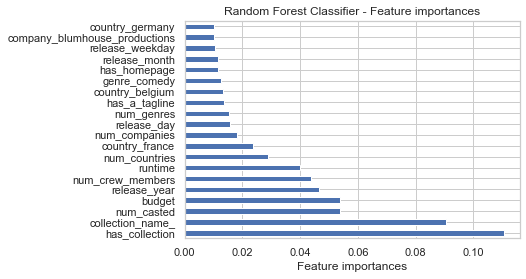

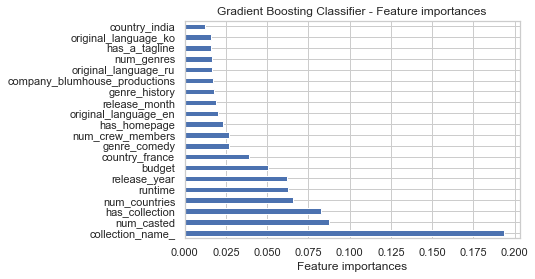

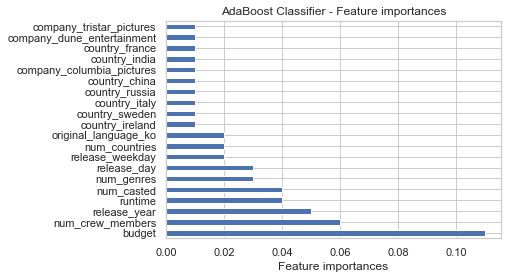

In [91]:
model_names = ["rfc", "gbc", "adac"]
inc = 0

for feature_importances in [rfc_feature_importances, gbc_feature_importances, adac_feature_importances]:
    
    features_importance = pd.Series(
        feature_importances,
        index=list(train_df.columns)
    ).sort_values(ascending=False)
    features_importance[:20].plot.barh()

    if model_names[inc] == "rfc":
        plt.title("Random Forest Classifier - Feature importances")
    if model_names[inc] == "gbc":
        plt.title("Gradient Boosting Classifier - Feature importances")
    if model_names[inc] == "adac":
        plt.title("AdaBoost Classifier - Feature importances")

    plt.xlabel('Feature importances')
    plt.show()
    inc += 1

We can observe that the three models have different features importance, nevertheless `budget`, `runtime`, `release_year`, `num_casted` and `num_crew_members` are often relevant features. 

Something interesting is that the variables related to the belonging to a collection are very important in the random forest classifier and the gradient boosting classifier, but it is not the case for the AdaBoost classifier, whereas we were expecting  very high relevance in all the classifiers ! (Indeed, great collections such as Star Wars, Lord of the Rings... are often very lucrative).